Channels present in data:
2    448
1    432
Name: channel, dtype: int64

--- Channel 2 ---
Metadata extraction preview:
   stab_conc_uM stab_name  mt_conc_uM  actin_conc_uM  channel  trial  time_PT  \
0           5.0        TX        3.19           2.62        2      3        6   
1           0.5        TX        3.19           2.62        2      1        1   
2           0.5        TX        3.19           2.62        2      1        1   
3           0.5        TX        3.19           2.62        2      1        1   
4           0.5        TX        3.19           2.62        2      1        1   

   spatial_x  spatial_y  
0          1          1  
1          0          0  
2          0          1  
3          1          0  
4          1          1  
Rows before filtering: 448, after filtering: 448


/Users/katarinamatic/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


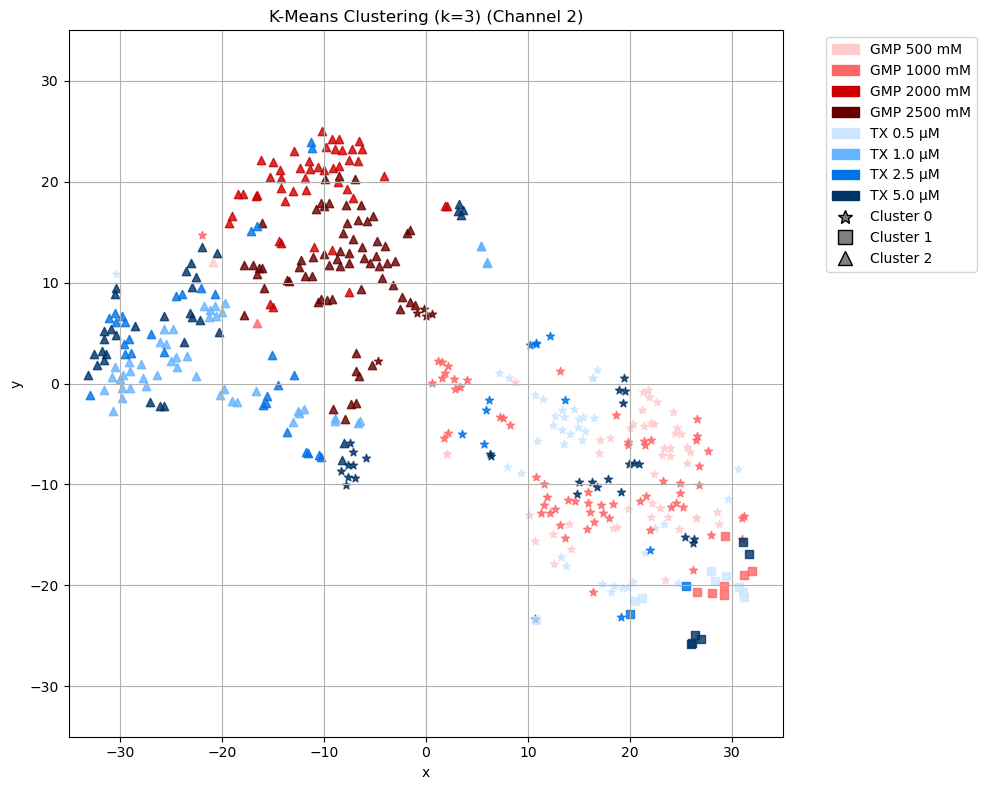

Saved filenames for cluster 0 to: ./cluster_outputs/cluster_assignments_channel_2_cluster_0.csv
Saved filenames for cluster 1 to: ./cluster_outputs/cluster_assignments_channel_2_cluster_1.csv
Saved filenames for cluster 2 to: ./cluster_outputs/cluster_assignments_channel_2_cluster_2.csv

--- Channel 1 ---
Metadata extraction preview:
   stab_conc_uM stab_name  mt_conc_uM  actin_conc_uM  channel  trial  time_PT  \
0           5.0        TX        3.19           2.62        2      3        6   
1           0.5        TX        3.19           2.62        2      1        1   
2           0.5        TX        3.19           2.62        2      1        1   
3           0.5        TX        3.19           2.62        2      1        1   
4           0.5        TX        3.19           2.62        2      1        1   

   spatial_x  spatial_y  
0          1          1  
1          0          0  
2          0          1  
3          1          0  
4          1          1  
Rows before filtering

/Users/katarinamatic/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


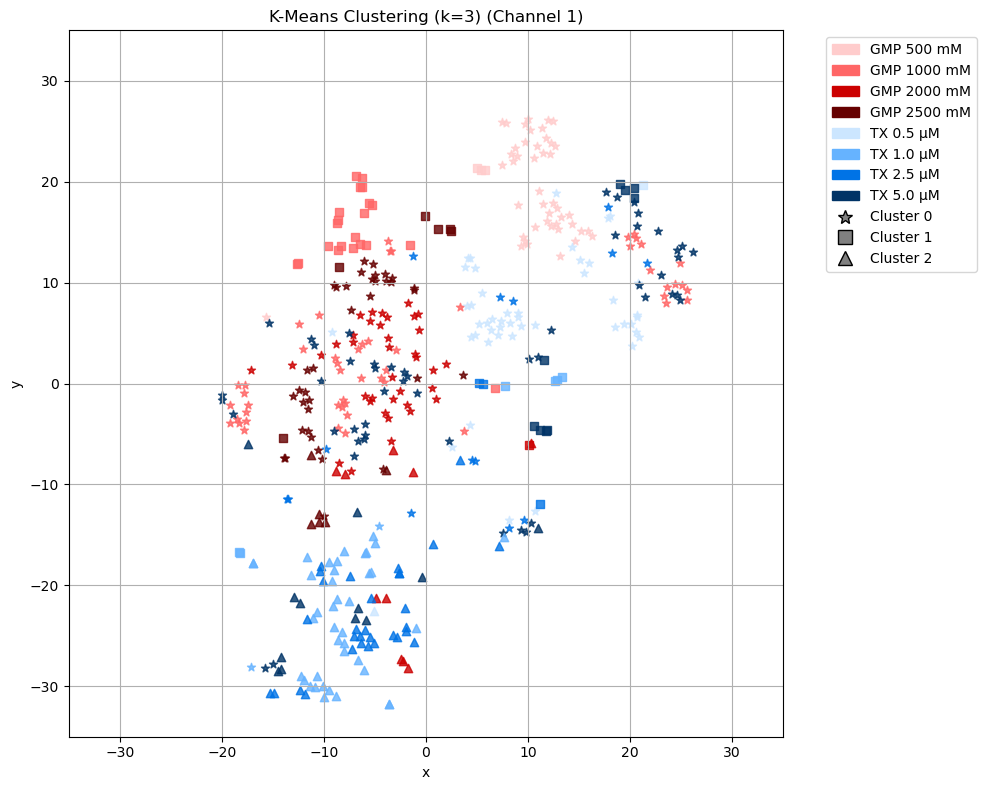

Saved filenames for cluster 0 to: ./cluster_outputs/cluster_assignments_channel_1_cluster_0.csv
Saved filenames for cluster 1 to: ./cluster_outputs/cluster_assignments_channel_1_cluster_1.csv
Saved filenames for cluster 2 to: ./cluster_outputs/cluster_assignments_channel_1_cluster_2.csv


In [1]:
from typing import Optional
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re
import os

metadata_columns = [
    "stab_conc_uM",
    "stab_name",
    "mt_conc_uM",
    "actin_conc_uM",
    "channel",
    "trial",
    "time_PT",
    "spatial_x",
    "spatial_y",
]

exclude_columns = [
    "Filename",
    "Channel",
    "Flags",
] + metadata_columns


def extract_metadata_from_filename(filename: str) -> dict:
    pattern1 = re.compile(
        r"(\d+\.?\d*)uM_([A-Z]+)_(\d+\.?\d*)uM-MT_(\d+\.?\d*)uM-A_C=(\d+)_trial-(\d+)_PT-(\d+)_tile_(\d+)_(\d+)\.tif"
    )

    pattern2 = re.compile(
        r"(\d+\.?\d*)mM-([A-Z]+)_trial-(\d+)_C=(\d+)_PT-(\d+)_tile_(\d+)_(\d+)\.tif"
    )

    match1 = pattern1.match(filename)
    match2 = pattern2.match(filename)

    if match1:
        parts = match1.groups()
        stab_conc, stab_name, mt_conc, actin_conc, channel, trial, time, x, y = parts
        return {
            "stab_conc_uM": float(stab_conc),
            "stab_name": stab_name,
            "mt_conc_uM": float(mt_conc),
            "actin_conc_uM": float(actin_conc),
            "channel": int(channel),
            "trial": int(trial),
            "time_PT": int(time),
            "spatial_x": int(x),
            "spatial_y": int(y),
        }

    elif match2:
        parts = match2.groups()
        stab_conc_mM, stab_name, trial, channel, time, x, y = parts
        stab_conc_uM = float(stab_conc_mM) * 1000
        stab_conc_uM = int(stab_conc_uM) if stab_conc_uM.is_integer() else stab_conc_uM
        return {
            "stab_conc_uM": stab_conc_uM,
            "stab_name": stab_name,
            "mt_conc_uM": 3.19,
            "actin_conc_uM": 2.62,
            "channel": int(channel),
            "trial": int(trial),
            "time_PT": int(time),
            "spatial_x": int(x),
            "spatial_y": int(y),
        }

    return {}  # No match


def get_data(channel: Optional[int] = None) -> tuple[pd.DataFrame, np.ndarray]:
    df = pd.read_csv("/Users/katarinamatic/Desktop/BARCODE_Higher_filament_930am.csv")

    if "Filename" not in df.columns:
        raise ValueError("No 'Filename' column found in the CSV!")

    df["Filename"] = df["Filename"].astype(str).str.strip()

    metadata_df = pd.DataFrame(df["Filename"].apply(extract_metadata_from_filename).tolist())

    print("Metadata extraction preview:")
    print(metadata_df.head())

    results_df = pd.concat([df, metadata_df], axis=1)

    # Filter by channel if specified
    if channel is not None:
        results_df = results_df[results_df["channel"] == channel]

    feature_columns = [col for col in results_df.columns if col not in exclude_columns]

    features_df = results_df[feature_columns].copy()
    metadata_only_df = results_df[metadata_columns].copy()

    valid_rows = ~metadata_only_df.isna().all(axis=1)
    print(f"Rows before filtering: {len(results_df)}, after filtering: {valid_rows.sum()}")
    features_df = features_df[valid_rows]
    metadata_only_df = metadata_only_df[valid_rows]

    if len(features_df) == 0:
        print(f"No valid rows after filtering and metadata extraction for channel {channel}. Skipping...")
        return pd.DataFrame(), np.array([])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_df)
    results_df.loc[features_df.index, feature_columns] = X_scaled

    return results_df.loc[features_df.index], X_scaled


from sklearn.manifold import TSNE

def run_clustering(
    df: pd.DataFrame,
    X_scaled: np.ndarray,
    k_opt: int = 3,
    title_suffix: str = "",
    output_dir: str = "./cluster_outputs",
):
    if df.empty or X_scaled.size == 0:
        print(f"No data available for clustering {title_suffix}. Skipping...")
        return df, None

    # Run KMeans directly on scaled data
    kmeans = KMeans(n_clusters=k_opt, random_state=0)
    clusters = kmeans.fit_predict(X_scaled)

    df = df.copy()
    df["cluster"] = clusters

    # Optional: Use t-SNE to visualize in 2D (instead of PCA)
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0)
    X_tsne = tsne.fit_transform(X_scaled)
    df["TSNE1"] = X_tsne[:, 0]
    df["TSNE2"] = X_tsne[:, 1]

    # Color + marker mapping
    cluster_markers = {0: "*", 1: "s", 2: "^"}
    gmp_color_map = {
        500: "#ffcccc", 1000: "#ff6666", 2000: "#cc0000", 2500: "#660000"
    }
    tx_color_map = {
        0.5: "#cce6ff", 1.0: "#66b3ff", 2.5: "#0073e6", 5.0: "#003366"
    }

    plt.figure(figsize=(10, 8))
    for cluster_id in sorted(df["cluster"].unique()):
        marker = cluster_markers.get(cluster_id, "x")
        cluster_df = df[df["cluster"] == cluster_id]

        for _, row in cluster_df.iterrows():
            x, y = row["TSNE1"], row["TSNE2"]
            name = row.get("stab_name", "")
            conc = row.get("stab_conc_uM", None)

            if name == "GMP" and conc in gmp_color_map:
                color = gmp_color_map[conc]
            elif name == "TX" and conc in tx_color_map:
                color = tx_color_map[conc]
            else:
                color = "gray"

            plt.scatter(x, y, color=color, marker=marker, alpha=0.8)

    # Legend
    import matplotlib.patches as mpatches
    from matplotlib.lines import Line2D

    legend_elements = (
        [mpatches.Patch(color=color, label=f"GMP {c} mM") for c, color in gmp_color_map.items()]
        + [mpatches.Patch(color=color, label=f"TX {c} µM") for c, color in tx_color_map.items()]
        + [Line2D([0], [0], marker=mk, color="w", label=f"Cluster {cid}", markerfacecolor="gray", markersize=10, markeredgecolor="black") for cid, mk in cluster_markers.items()]
    )

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-35, 35)
    plt.ylim(-35, 35)
    plt.title(f"K-Means Clustering (k={k_opt}) {title_suffix}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save cluster CSVs
    os.makedirs(output_dir, exist_ok=True)
    if "Filename" in df.columns:
        for cluster_id in range(k_opt):
            cluster_filenames = df[df["cluster"] == cluster_id]["Filename"]
            out_path = os.path.join(
                output_dir,
                f"cluster_assignments_channel_{title_suffix.strip('()').split()[-1]}_cluster_{cluster_id}.csv",
            )
            cluster_filenames.to_csv(out_path, index=False)
            print(f"Saved filenames for cluster {cluster_id} to: {out_path}")

    return df, clusters



if __name__ == "__main__":
    df_full = pd.read_csv("/Users/katarinamatic/Desktop/BARCODE_Higher_filament_930am.csv")
    df_full["Filename"] = df_full["Filename"].astype(str).str.strip()
    metadata_full = pd.DataFrame(df_full["Filename"].apply(extract_metadata_from_filename).tolist())

    print("Channels present in data:")
    print(metadata_full["channel"].value_counts())

    available_channels = metadata_full["channel"].dropna().unique().astype(int).tolist()

    for ch in available_channels:
        print(f"\n--- Channel {ch} ---")
        df, X_scaled = get_data(channel=ch)
        df_with_clusters, clusters = run_clustering(
            df, X_scaled, k_opt=3, title_suffix=f"(Channel {ch})"
        )
